# ANALISIS DE DATOS DE IMÁGENES .fits

## Análisis de los clústers

la idea de este notebook es organizar la información del análisis de los clusters y descargar todo aquello que es redundante, como imágenes y código de prueba que puede encontrarse en el notebook ```Análisis_de_Imagenes.ipynb```

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

In [2]:
import skimage.measure
from scipy import ndimage as ndi
from scipy.stats import poisson
import pandas as pd

probabilidad = 0.2253

In [3]:
"""
author: Santiago Ezequiel Perez
Quien amablemente me pasó estas funciones para usarlas
"""

def get_cluster_info(image, labels):
    """
    Parameters
    ----------
    image : numpy array
        DESCRIPTION:
        Array de numpy con los datos de la imagen
    labels : numpy array
        DESCRIPTION.
        Array de numpy de la misma estructura dimensional que el array
        imagen. Contiene 0 donde no hay features y contiene enteros 
        crecientes para etiquetar (labelear) los features.
    ----------
    Returns: dict
        DESCRIPTION:
        Diccionario con las siguientes keys:
            areas,
            centros,
            coordenadas,
            perimetro,
            energias,
            box
    """
    def image_intensity(region, intensities):
        """
        Es una función interna de get_cluster_info
        Suma las intensidades de una region en unidades de electrones
        """
        return np.sum(intensities[region])

    rps = skimage.measure.regionprops(labels,
                                      intensity_image=image,
                                      cache=False,
                                      extra_properties=[image_intensity])
    areas = [r.area for r in rps]
    energy = [r.image_intensity for r in rps]
    centros = [r.centroid for r in rps]
    coords = [r.coords for r in rps]
    perimetro = [r.perimeter for r in rps]
    
    dic_props = {"areas": areas,
                 "centros": centros,
                 "coordenadas": coords,
                 "perimetro": perimetro,
                 "energias": energy}
    return dic_props

def img2bw(image, lower_thresh=None, upper_thresh=None):
    """
    Binariza la imagen ingresada según el threshold dado:
    Parameters
    ----------
    image : numpy array
        DESCRIPTION:
        Array de numpy con los datos de la imagen
    lowel_trhesh : int - float, optional
        DESCRIPTION.
        threshold minimo para el binarizado de la imagen.
        Si nada es ingresado, entonces se toma como nulo
    upper_trhesh : int - float, optional
        DESCRIPTION.
        threshold máximo para el binarizado de la imagen.
        Si nada es ingresado, entonces se toma como nulo
    ----------
    Returns: numpy array of bools
        DESCRIPTION:
        array de numpy con la misma dimensionalidad que el
        input, pero con todos valores booleanos.
    """
    if lower_thresh is None:
        lower_thresh = 0
    if upper_thresh is None:
        upper_thresh = np.max(image) + 1
    return (image >= lower_thresh) & (image <= upper_thresh)

Tengo que definir las demás funciones también

In [4]:
def regresion_lineal(X, Y):
    """
    Parameters
    ----------
    X : array like
        DESCRIPTION
    Y : array like
        DESCRIPTION
    returns: m y b de la linea mx + b
    """
    N = len(X)
    Delta = N*sum(X**2) - (sum(X))**2
    m = (N*sum(X*Y) - sum(X)*sum(Y))/Delta
    b = (sum(X**2)*sum(Y) - sum(X)*sum(X*Y))/Delta

    return m, b

def fits_finder(directorio=".", extension=".fits"):
    """
    Parameters
    ----------
    directorio : string, optional
        DESCRIPTION. The default is "."
        El directorio "madre" del cual se quieren buscar las imágenes .png
        de todos sus subdirectorios
    extension : string, optional
        DESCRIPTION. The default is ".png"
        La extensión del tipo de archivo que se quiere buscar en los
        subdirectorios. Es necesario usar ".extension": EJ: ".png", ".jpg"
    Returns: string de directorios y archivos .png
    """
    archivos = []
    for root, dirs, files in os.walk(directorio):
        for name in files:
            path = os.path.join(root, name)
            size = os.stat(path).st_size/1000
            if path.endswith(extension) and size < 500:
                archivos.append(path)
    return archivos


def ADU2e(src_path, alpha=20138e-7, beta=323e-13, ohdu=0, save=False):
    """

    From a .fits image, and using the polynomial fit for ADU -> electron
    returns both image data:
        image in ADU's
        image in e- units.

    Parameters
    ----------
    src_path : string
        Directory path of the file
    alpha : float, optional
        By default, alpha = 20138e-7
        refs: DE DONDE SALEN ESTOS NUMEROS?
        ref: Tesis Kevin Anderson, tabla 3.1: alpha = 1.99e-3
    beta : float, optional
        By default, beta = 323e-13
        refs: DE DONDE SALEN ESTOS NUMEROS?
        ref: Tesis Kevin Anderson, tabla 3.1: beta = 8.61e-11
    ohdu : int, optional
        0, 1, 2, 3 allowed (each sensor of the total sensor)
    save : bool, optional
        When set True, a new fits file in electron units is saved
    """
    with fits.open(src_path) as fits_img:
        ADU_img_data = fits_img[ohdu].data
        e_img_data = np.round(ADU_img_data*alpha + ADU_img_data**2*beta)
        # =====================================
        # Los datos vienen con valores negativos:
        # filtro los valores negativos y los transformo en 0
        ADU_img_data[ADU_img_data < 0] = 0
        e_img_data[e_img_data < 0] = 0

        if save is True:
            fits_img[ohdu].data = e_img_data
            tgt_path = src_path.strip(".fits") + "electron_units.fits"
            fits_img.writeto(tgt_path)
    return e_img_data, ADU_img_data


def single_fits2double_fits(src_path, tgt_path="", threshold=1, ohdu=0,
                            save=False):
    """

    From one .fits file generates 2 new fits files.

    Parameters
    ----------
    src_path : string
        Path to the original .fits file or filename
    tgt_path : string
        path to the 2 new .fits files or filename WITHOUT EXTENSION.
        e.g /media/usr/.../image_name <-- correct
        e.g /media/usr/.../image_name.fits <-- incorrect
    threshold : int, optional
        Threshold to start counting electrons. The data will be divided into
        two diferents arrays, one with all pixels having a number of electrons
        greater than threshold and the other one having the rest.
        The default is 1.
    ohdu : int, optional.
        0,1,2,3 allowed (each sensor of the total sensor)
    save : bool, optional.
        If set True, then generates the 2 .fits files with the threshold
        applied
    Returns
    -------
    None.

    """
    electron_fits = ADU2e(src_path, ohdu=ohdu)[0]

    # make some copies of the original data to modify it avoiding aliasing
    elec_minor = electron_fits.copy()
    elec_major = electron_fits.copy()

    # All pixels with a number of electrons > threshold are set to 0
    elec_minor[elec_minor > threshold] = 0
    # All pixels with a number of electrons < threshold are set to 0
    elec_major[elec_major <= threshold] = 0

    # differenciate the minor and major paths
    tgt_path_minor = tgt_path + "minor.fits"
    tgt_path_major = tgt_path + "major.fits"
    if save is True:
        with fits.open(src_path) as fits_img:
            # save elec_minor
            fits_img[ohdu].data = elec_minor
            try:
                fits_img.writeto(tgt_path_minor)
            except OSError as e:
                print(e)
                print("A file with the same name already exists.")
            # save elec_major
            fits_img[ohdu].data = elec_major
            try:
                fits_img.writeto(tgt_path_major)
            except OSError as e:
                print(e)
                print("A file with the same name already exists.")
    return elec_minor, elec_major

Guardo en lista todo los directorios de las imágenes:

In [5]:
DIR = "/home/igna/Escritorio/Tesis2021/Archivos/T123K"
os.chdir(DIR)
fits_imgs_list = fits_finder(DIR)

###### El procedimiento para reconocer clústers sería el siguiente:
- Me genero el array de numpy que contiene la data de la imagen fits con ```ADU2e```.
- Binarizo la imagen usando ```img2bw``` y la guardo en una nueva variable con sufijo ```_bw```. La imagen binarizada es un array de True's y False's. Se pierde la información de intesidades.
- Me armo mis "features labels" usando ```ndi.label``` dándole de comer a esa funcion la imagen binarizada a partir del threshold dado.
- El argumento ```structure``` de ```ndi.label``` define la forma en la que se conectan los features (en mi caso clusters)
- Con ```get_cluster_info``` (que ya la modifiqué para que me de más propiedades) obtengo la información de los "features" que ndi encontró, en este caso los clusters. El input es el array de numpy con la información de la imagen y los labels que escupe ```ndi.labels```. El output es un diccionario con las siguientes keys: 
    - areas
    - centros
    - coordenadas
    - perimetro
    - energias
    - box
- ploteo la imagen y marco con círculos los clusters que reconoció (opcional - acá no)

Este procedimiento lo voy a aplicar tanto a imagenes originales como a imágenes a las que les voy a agregar ruido sintéticamente utilizando el valor $\mu$ calculado en ```Analisis_imagenes_probabilidad.ipynb``` que es
$\mu = 0.2235 \pm 0.0001$

Voy a trabajar con 3 DataFrames diferentes:
- df_o (df_original) para la información de los clusters detectados en las imágenes originales
- df_l (df_labeled) para la información de los clusters de las imágenes con ruido simulado, usando labels originales
- df_s (df_simulated) para la información de los nuevos clústers al agregar ruido simulado a las imágenes.

Defino 2 funciones: ```image2cluster_info``` y ```df_gen```. La primera extrae toda la información de las imágenes, ya sea originales o simuladas y devuelve 3 listas con la información necesaria para pasarle a df_gen para armar los DataFrames correspondientes

In [6]:
#=============================================================================

def image2cluster_info(fits_imgs_list, low_th=2, img="o"):
    """
    Extrae la información de los clusters de todas las imágenes y lo guarda en
    listas
    Parameters
    ----------
    fits_imgs_list : list
        DESCRIPTION.
        lista de directorios donde están las imágenes .fits
    img : str - optional
        DESCRIPTION.
        para indicarle si va a buscar clusters:
            "o": Busca los features en la imagen original.
            "l": Busca los features en la imagen simulada, pero usa los labels
            para de la imagen original.
            "s": Busca los features de la iamgen simulada.
    low_th : int - optional
        DESCRIPTION.
        lower_threshold
    ----------
    Returns: lista_dics, lista_b_features, lista_img_idxs
        DESCRIPTION:
        lista con la información
    """
    
    # Armo listas donde guardo la info
    lista_dics = []
    lista_n_features = []
    lista_img_idxs = []
    
    # Hardcodeo el mu de la poissoniana
    mu = 0.2253

    # recorro las imagenes que quiero usar
    for i, image in enumerate(fits_imgs_list):
        # Imagen completa
        image_o = ADU2e(image, ohdu=0)[0]
        
        # Imagen con clústers unicamente
        image_s = single_fits2double_fits(image, ohdu=0)[1]
        # Le agrego ruido a la imagen con clusters unicamente
        image_s += poisson.rvs(mu, size=(50, 493))

        # Binarizo ambas imagenes:
        image_o_bw = img2bw(image_o, lower_thresh=low_th, upper_thresh=300)
        image_s_bw = img2bw(image_s, lower_thresh=low_th, upper_thresh=300)

        # Genero las labels y también guardo el número de features
        label_im_o, n_features_o = ndi.label(image_o_bw,
                                             structure=[[0, 1, 0],
                                                        [1, 1, 1],
                                                        [0, 1, 0]])
        label_im_s, n_features_s = ndi.label(image_s_bw,
                                             structure=[[0, 1, 0],
                                                        [1, 1, 1],
                                                        [0, 1, 0]])

        # Armo el diccionario con información que devuelve get_cluster_size_etc
        if img == "o":
            dic = get_cluster_info(image_o, label_im_o)
            n_features = n_features_o
        elif img == "l":
            dic = get_cluster_info(image_s, label_im_o)
            n_features = n_features_o
        elif img == "s":
            dic = get_cluster_info(image_s, label_im_s)
            n_features = n_features_s
        else:
            print("opción incorrecta: Solo 'o', 'l', 's' son válidos")
            return 0
        lista_dics.append(dic)
        lista_n_features.append(n_features)
        lista_img_idxs.append(np.ones(n_features)*i)
        # Printeo el progreso del ciclo for
        print("\r%.2f%%" % (100*(i+1)/925), end = "")
    
    return lista_dics, lista_img_idxs


def df_gen(lista_dics, lista_img_idxs):
    """
    Esta función arma a partir de la listas de información un DataFrame de 
    pandas para manipular la información más comodamente
    Parameters
    ----------
    lista_dics : list
        DESCRIPTION:
        lista de diccionarios
    lista_img_idxs : list
        DESCRIPTION.
        lista de índices para identificar una misma imagen
    ----------
    Returns: pd.DataFrame
        DESCRIPTION:
        DataFrame con toda la información de las imágenes
    """
    
    # armo listas para meter los datos
    energias = []
    areas = []
    centros = []
    perimetros = []
    
    # meto los datos en las listas
    for dics in lista_dics:
        energias += dics["energias"]
        areas +=dics["areas"]
        centros +=dics["centros"]
        perimetros += dics["perimetro"]
        
    # concateno los índices para que sea un solo array
    lista_img_idxs = np.concatenate(lista_img_idxs)
    
    # Armo el dicionario
    diccionario = {}
    diccionario["img_idx"] = lista_img_idxs
    diccionario["energia"] = energias
    diccionario["area"] = areas
    diccionario["centro"] = centros
    diccionario["perimetro"] = perimetros
    
    return pd.DataFrame.from_dict(diccionario)

Si tengo hechos los archivos, los abro como DataFrames. Si no, empiezo a buscar clusters con el algoritmo en las imagenes originales (puede tardar unos minutos) y los transformo a DataFrames

In [7]:
#=============================================================================
# PARA CARGAR LOS DATOS SIN CORRERLOS CADA VEZ
os.chdir("/media/igna/ignag/Igna/Facultad/Tesis2021/AnalisisImagenesFits/")


# Si los archivos existen en el directorio, los cargo
if ("data_original.csv" in os.listdir()
    and "data_l_original.csv" in os.listdir()
    and "data_sim.csv" in os.listdir()):

    df_o = pd.read_csv("data_original.csv", sep="\t")
    df_l = pd.read_csv("data_l_original.csv", sep="\t")
    df_s = pd.read_csv("data_sim.csv", sep="\t")

# Si no, los genero (pero puede tardar un rato) y armo los DataFrame
else:
    # datos de las imagenes originales
    lista_dics_o, lista_img_idx_o = image2cluster_info(fits_imgs_list, img="o")
    print("\nListo las originales!\n")
    # datos de imágenes simuladas pero usando los labels de la original
    lista_dics_l, lista_img_idx_l = image2cluster_info(fits_imgs_list, img="l")
    print("\nListo las 'medio' simuladas!\n")
    # datos de imágenes simuladas 100%
    lista_dics_s, lista_img_idx_s = image2cluster_info(fits_imgs_list, img="s")
    print("\nListo las simuladas!\n")
    
    # originales
    df_o = df_gen(lista_dics_o, lista_img_idx_o)
    # simulados con labels originales
    df_l = df_gen(lista_dics_l, lista_img_idx_l)
    # 100% simulados
    df_s = df_gen(lista_dics_s, lista_img_idx_s)

In [8]:
# Creo un DataFrame para las diferencias entre originales y medio simuladas
df_diff_ol = df_o.copy()
df_diff_ol["diff"] = abs(df_o["energia"]-df_l["energia"])
df_diff_ol.set_index("img_idx", inplace=True)
df_diff_ol.drop(["Unnamed: 0"], axis=1, inplace=True)
df_diff_ol

,energia,area,centro,perimetro,diff
img_idx,,,,,
0.0,2.0,1,"(1.0, 434.0)",0.000000,0.0
0.0,4.0,2,"(13.0, 68.5)",0.000000,0.0
0.0,29.0,8,"(16.0, 276.5)",6.000000,1.0
0.0,6.0,3,"(18.666666666666668, 144.66666666666666)",3.414214,1.0
0.0,2.0,1,"(19.0, 300.0)",0.000000,0.0
...,...,...,...,...,...
924.0,2.0,1,"(49.0, 341.0)",0.000000,0.0
924.0,2.0,1,"(49.0, 357.0)",0.000000,1.0
924.0,4.0,2,"(49.0, 359.5)",0.000000,1.0


In [9]:
#=============================================================================
# Ahora inteto matchear eventos de mismas imágenes
#
df_diff_os = pd.DataFrame()
Diff = pd.DataFrame()

index = np.arange(0, 925, 1)

for idx in index:

    df_aux_o = df_o[df_o["img_idx"] == idx]
    df_aux_s = df_s[df_s["img_idx"] == idx]
    
    df_coincidente_o = df_aux_o.loc[df_aux_o["centro"]
                                    .isin(df_aux_s["centro"])].copy()
    df_coincidente_s = df_aux_s.loc[df_aux_s["centro"]
                                    .isin(df_aux_o["centro"])].copy()
    
    df_coincidente_o.reset_index(inplace=True)
    df_coincidente_s.reset_index(inplace=True)
    
    df_coincidente_o.set_index("img_idx", inplace=True)
    df_coincidente_s.set_index("img_idx", inplace=True)
    
    df_coincidente_o.drop(["Unnamed: 0", "index"], axis=1, inplace=True)
    df_coincidente_s.drop(["Unnamed: 0", "index"], axis=1, inplace=True)
    
    df_diff_os = df_diff_os.append(df_coincidente_o.copy())
    
    diff = df_coincidente_o[["energia"]] - df_coincidente_s[["energia"]]
    
    Diff = Diff.append(abs(diff))
    print("\r%.2f%%" % (idx*100/924), end=" ")

df_diff_os["diff"] = Diff
df_diff_os

100.00% 

,energia,area,centro,perimetro,diff
img_idx,,,,,
0.0,2.0,1,"(1.0, 434.0)",0.000000,0.0
0.0,4.0,2,"(13.0, 68.5)",0.000000,1.0
0.0,6.0,3,"(18.666666666666668, 144.66666666666666)",3.414214,0.0
0.0,2.0,1,"(19.0, 300.0)",0.000000,0.0
0.0,27.0,3,"(19.666666666666668, 327.6666666666667)",3.414214,0.0
...,...,...,...,...,...
924.0,2.0,1,"(49.0, 341.0)",0.000000,1.0
924.0,2.0,1,"(49.0, 357.0)",0.000000,1.0
924.0,4.0,2,"(49.0, 359.5)",0.000000,0.0


Por último, tanto a ```df_diff_ol``` y ```df_diff_os``` voy a agregarles dos columnas: 
- Una para la esperanza de la cantidad de carga por cluster (en función del área) para una distribución binomial de la cantidad de eventos por píxel.
- Otra para la esperanza de la cantidad de carga por cluster (en función del área) para una distribución poissoniana de la cantidad de eventos por píxel.

La esperanza de una Binomial viene dada simplemente por 
\begin{equation}
    E(k) = np
\end{equation}

donde $n$ es el número de píxeles y $p$ es la probabilidad de que haya una carga en el píxel.

La esperanza de la Poisson en función de la cantidad de píxeles la calculo de la siguiente manera: Si $\mu$ es la esperanza de la Poissoniana para un dado píxel, entonces si $k$, variable aleatoria con distribución Poissoniana, es el número de electrones espurios por píxel, la esperanza de la variable aleatoria $k$ viene dada por $E(k) = \mu$. Pero para un clúster de $N$ píxeles, el número de electrones espurios por clúster será

$$ n = \sum\limits_{i=1}^{N}k_{i}$$

donde $k_{i}$ es la cantidad de electrones espurios en el píxel $i$-ésimo y $N$ es la cantidad de píxeles del cluster. Entonces, quiero calcular la esperanza de $n$, $E(n)$, y como la esperanza de la suma es la suma de las esperanzas, se tiene

$$E(n) = E\left( \sum\limits_{i=1}^{N} k_{i}\right) = \sum\limits_{i=1}^{N}E(k_{i})$$

como la esperanza de la distribución es la misma, para cualquier $k_{i}$ es el mismo $\mu$, entonces

$$E(n) = \mu \sum\limits_{i=1}^{N} 1 = N \mu,$$

Entonces, la esperanza de la variable aleatoria **número de electrones espurios en un cluster** viene dada por $N\mu$, muy parecida a la binomial.

Como $p$ y $\mu$ son lo mismo, entonces ambas esperanzas son las mismas! Entonces no agrego dos columnas, agrego una sola que se llama esperanza.

In [10]:
df_diff_ol["esperanza"] = df_diff_ol["area"]*probabilidad
df_diff_os["esperanza"] = df_diff_os["area"]*probabilidad

## Histogramas de carga para cada dataset
#### original
#### simulado y labels originales
#### simulado 100%

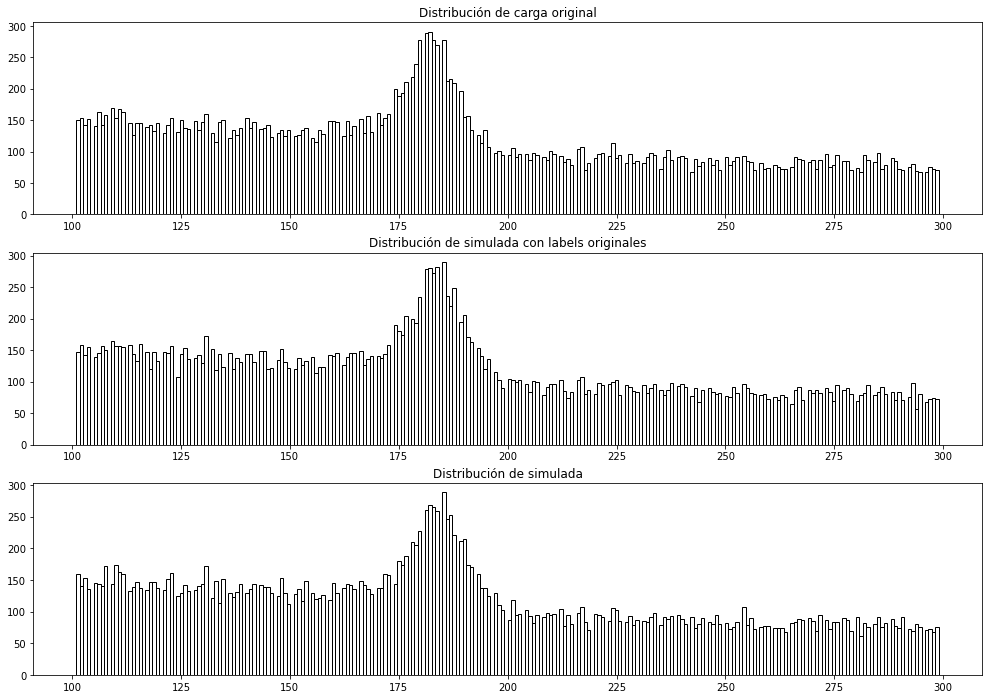

In [11]:
energia_o = df_o[(df_o["energia"]>100) & (df_o["energia"]<300)]["energia"]
energia_l = df_l[(df_l["energia"]>100) & (df_l["energia"]<300)]["energia"]
energia_s = df_s[(df_s["energia"]>100) & (df_s["energia"]<300)]["energia"]
fig, axs = plt.subplots(3,1, figsize=(17,12))

axs[0].set_title("Distribución de carga original")
axs[0].hist(energia_o, bins=250, fill=False)
axs[1].set_title("Distribución de simulada con labels originales")
axs[1].hist(energia_l, bins=250, fill=False)
axs[2].set_title("Distribución de simulada")
axs[2].hist(energia_s, bins=250, fill=False);

## Comparación entre datos medidos, simulaciones y teórico
### Caso simulado con labels originales

In [12]:
# =============================================================================
# nuevo DataFrame
DF_ol = df_diff_ol[["area", "diff", "esperanza"]].groupby("area").mean()
DF_ol["error"] = df_diff_ol[["area", "diff"]].groupby("area").std()
# reseteo el índice 
DF_ol.reset_index(inplace=True)

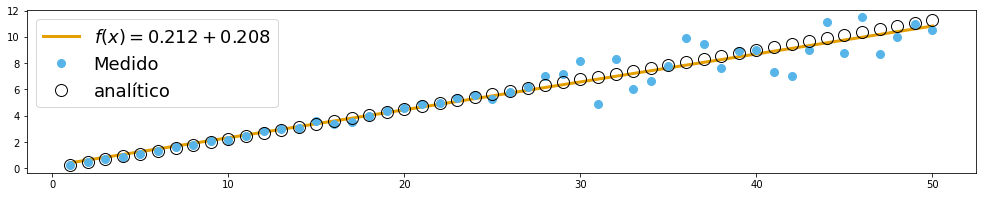

In [13]:
# Hago el ajuste
m, b = regresion_lineal(DF_ol["area"].head(50), DF_ol["diff"].head(50))


plt.figure(figsize=(17, 3))
# ploteo el ajuste
plt.plot(DF_ol["area"].head(50), DF_ol["area"].head(50)*m + b, 
         color="#E69F00",
         linewidth=3,label="$f(x)=%.3f + %.3f$" % (m, b))

# ploteo los datos promediados
plt.plot(DF_ol["area"].head(50), DF_ol["diff"].head(50),
         'o',
         color="#56B4E9", 
         markersize=8,
         label="Medido")

# ploteo la teórica (binomial) con circulos abiertos
plt.plot(DF_ol["area"].head(50), DF_ol["esperanza"].head(50),
         'o',
         color="k",
         markersize=12,
         fillstyle="none",
         label="analítico")
plt.legend(fontsize=18);
#plt.savefig("BinomialVSMontecarlo.pdf")

### Caso 100% simulado

In [14]:
# =============================================================================
# nuevo DataFrame
DF_os = df_diff_os[["area", "diff", "esperanza"]].groupby("area").mean()
DF_os["error"] = df_diff_os[["area", "diff"]].groupby("area").std()
# reseteo el índice 
DF_os.reset_index(inplace=True)

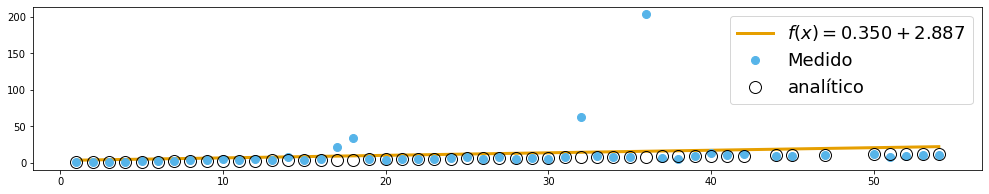

In [15]:
# Hago el ajuste
m, b = regresion_lineal(DF_os["area"].head(50), DF_os["diff"].head(50))


plt.figure(figsize=(17, 3))
# ploteo el ajuste
plt.plot(DF_os["area"].head(50), DF_os["area"].head(50)*m + b, 
         color="#E69F00",
         linewidth=3,label="$f(x)=%.3f + %.3f$" % (m, b))

# ploteo los datos promediados
plt.plot(DF_os["area"].head(50), DF_os["diff"].head(50),
         'o',
         color="#56B4E9", 
         markersize=8,
         label="Medido")

# ploteo la teórica (binomial) con circulos abiertos
plt.plot(DF_os["area"].head(50), DF_os["esperanza"].head(50),
         'o',
         color="k",
         markersize=12,
         fillstyle="none",
         label="analítico")
plt.legend(fontsize=18);
#plt.savefig("BinomialVSMontecarlo.pdf")